# Chapter 9 - Support Vector Machines
The topics of this chapter are

- Support Vector Classifiers
- Support Vector Machines

Three packages are used in the examples of this chapter: e1071, ISLR, ROCR.

### 9.6.1 Support Vector Classifier
We simulate the data taking a random sample of data points in two dimensions, $X(X_1, X_2)$ to create two classes of points, in a two-dimensional space, that are not linearly separable. 

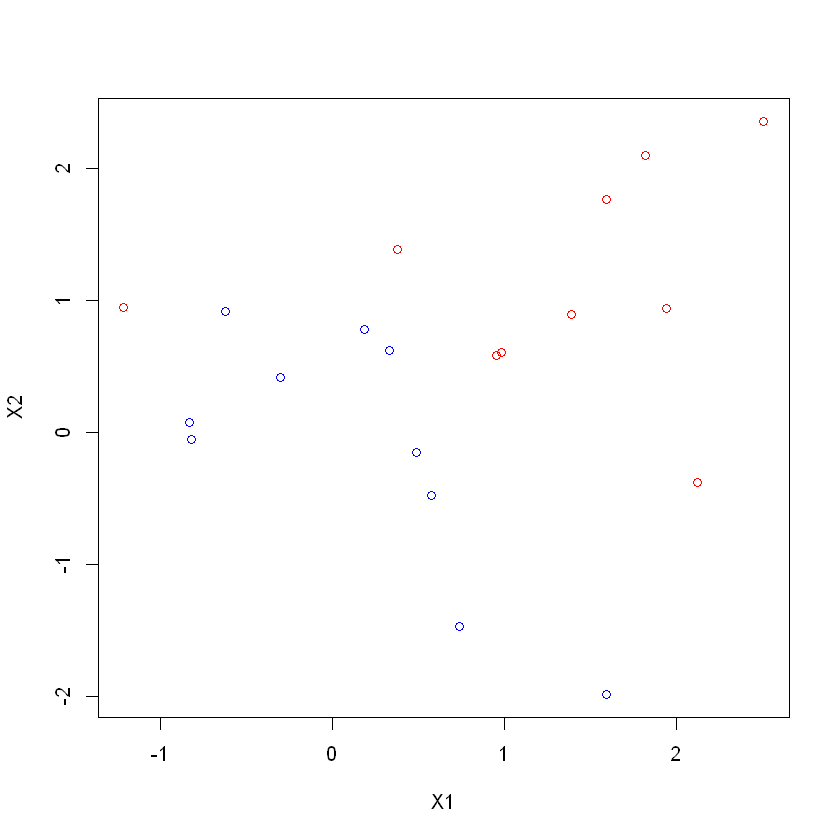

In [34]:
set.seed(1)
X <- matrix(rnorm(20 * 2), ncol = 2) # random sample from a normal distribution with mean = 0 and standard deviation = 1
y <- c(rep(-1, 10), rep(1, 10)) # two classes y = -1 and y = 1
X[y == 1, ] <- X[y == 1, ] + 1 # adds 1 to 10 data points
plot(X, col = (3 - y), xlab = "X1", ylab = "X2") # plots the data points with different colors, y = 1 -> red (2), y = - 1 -> blue (4)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




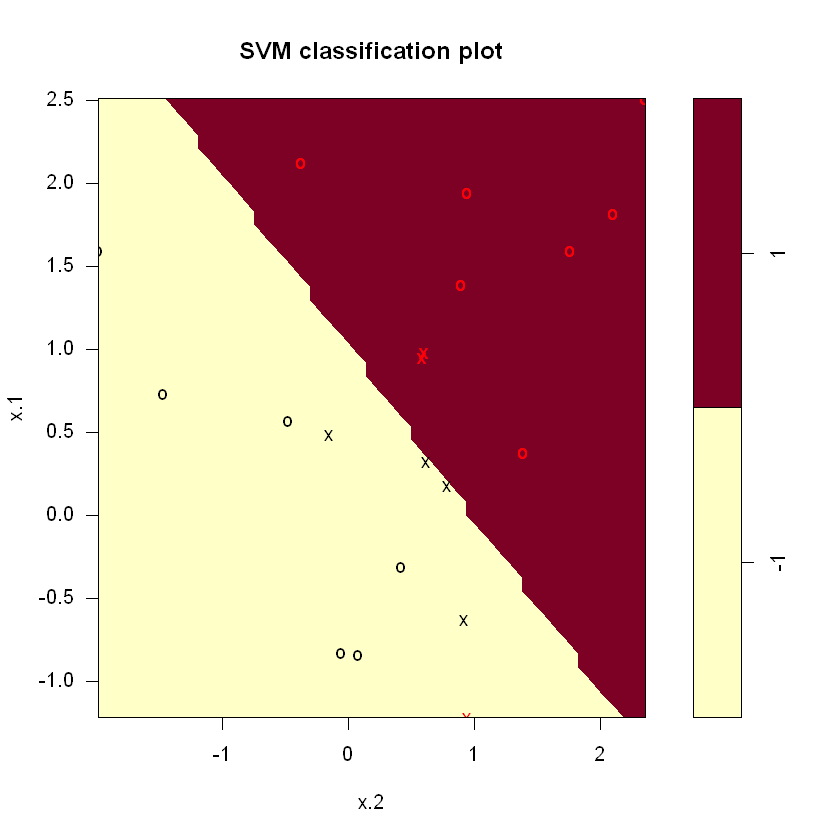

In [40]:
dat <- data.frame(x = X, y = as.factor(y)) # the response variable is encoded as a variable of (two) classes
library(e1071)
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE) 
summary(svmfit)
plot(svmfit, dat)

We try now different values of the cost, the higher is the value of the cost the larger is the margin and the more data point are allowed to be between the margin and the decision boundary.

In [59]:
set.seed(1)
cost_range = c(0.001, 0.01, 0.1, 1.5, 10, 100)
tune.out <- tune(svm, y ~ ., data = dat, kernel = "linear", ranges = list(cost = cost_range))
summary(tune.out)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.05 

- Detailed performance results:
     cost error dispersion
1   0.001  0.55  0.4377975
2   0.010  0.55  0.4377975
3   0.100  0.05  0.1581139
4   1.500  0.15  0.2415229
5  10.000  0.15  0.2415229
6 100.000  0.15  0.2415229


We can see that the lowest cross-validation error is when cost = 0.1. We will use the best model, with cost = 0.1, to make predictions. Before that we need to create a test set of observations.